<a href="https://colab.research.google.com/github/mharrisonbaker/DATA620/blob/main/Academic_Citation_Graph_Data620final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [133]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import random
import string
import re
import json
from itertools import islice
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [72]:
df = pd.read_json('/content/drive/MyDrive/academic_citation_v10/dblp-ref-3.json', lines=True)

In [73]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id
0,AdaBoost algorithm based on Haar-like features...,"[Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...",0,"[0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...",A Heterogeneous System for Real-Time Detection...,high performance computing and communications,2016,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e
1,"In this paper, a kind of novel jigsaw EBG stru...","[Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]",0,[],A novel conformal jigsaw EBG structure design,international conference on conceptual structures,2016,002e0b7e-d62f-4140-b015-1fe29a9acbaa
2,This paper studies the problem of using an aut...,"[Xiaodong Ai, Keyou You, Shiji Song]",0,"[1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...",A source-seeking strategy for an autonomous un...,"international conference on control, automatio...",2016,00352759-f0a7-4678-82ae-fed68c700da6
3,NaN,"[Francine Berman, Vinton G. Cerf]",0,[],Social and ethical behavior in the internet of...,Communications of The ACM,2017,00f77fa9-ae49-4935-9166-2f5f9cdb3d6b
4,NaN,"[Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...",50,"[4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...",Prediction of consensus binding mode geometrie...,Journal of Computational Chemistry,2017,013ea675-bb58-42f8-a423-f5534546b2b1


In [74]:
#drop rows with NaN values 
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)


In [75]:
#remove punctuation from abstract and title fields
p = re.compile(r'[^\w\s]+')
df['abstract'] = [p.sub('', x) for x in df['abstract'].tolist()]
df['title'] = [p.sub('', x) for x in df['title'].tolist()]


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35174 entries, 0 to 35173
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract    35174 non-null  object
 1   authors     35174 non-null  object
 2   n_citation  35174 non-null  int64 
 3   references  35174 non-null  object
 4   title       35174 non-null  object
 5   venue       35174 non-null  object
 6   year        35174 non-null  int64 
 7   id          35174 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.1+ MB


In [106]:
# #cast text to lowercase for purposes of tf-idf processing
# df['abstract']=df['abstract'].str.lower()
# df['title']=df['title'].str.lower()

In [107]:
df2=df.copy()

In [108]:
#combine text columns for tf-idf processing
df2["text"] = df["abstract"] + df["title"]
# del df2['abstract']
# del df2['title']


In [109]:
df2['text']= df2['text'].astype(str)

In [110]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35174 entries, 0 to 35173
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract    35174 non-null  object
 1   authors     35174 non-null  object
 2   n_citation  35174 non-null  int64 
 3   references  35174 non-null  object
 4   title       35174 non-null  object
 5   venue       35174 non-null  object
 6   year        35174 non-null  int64 
 7   id          35174 non-null  object
 8   text        35174 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.4+ MB


In [111]:
#removed this as it is done below
#remove stop words from columns
# stop = stopwords.words('english')
# df2["text"] = df2["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [112]:
stemmer = SnowballStemmer("english")
df2['stemmed'] = df2['text'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

In [113]:
cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
cvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [114]:
# Calculate all the n-grams found in all documents
cvec.fit(df2.stemmed)
list(islice(cvec.vocabulary_.items(), 20))

[('adaboost', 62571),
 ('algorithm', 83929),
 ('base', 170204),
 ('haarlik', 679294),
 ('featur', 591501),
 ('achiev', 53951),
 ('high', 695198),
 ('accuraci', 51410),
 ('abov', 42523),
 ('95', 38531),
 ('object', 1019728),
 ('detect', 428468),
 ('meanwhil', 906146),
 ('massiv', 896095),
 ('comput', 308015),
 ('power', 1134346),
 ('need', 982725),
 ('implement', 732745),
 ('cascad', 229985),
 ('classifi', 265063)]

In [115]:
len(cvec.vocabulary_)

1671097

In [116]:
cvec = CountVectorizer(stop_words='english', min_df=.003, max_df=.25, ngram_range=(1,2))
cvec.fit(df2.stemmed)
len(cvec.vocabulary_)

3284

In [117]:
cvec_counts = cvec.transform(df2.stemmed)
print ('sparse matrix shape:', cvec_counts.shape)
print ('nonzero count:', cvec_counts.nnz)
print ('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (35174, 3284)
nonzero count: 1993480
sparsity: 1.73%


In [118]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
1900,network,23123
2266,problem,15643
823,differ,13065
1428,inform,12925
2998,time,12884
560,comput,12612
783,design,12481
3149,user,11992
1359,imag,11900
2004,optim,11564


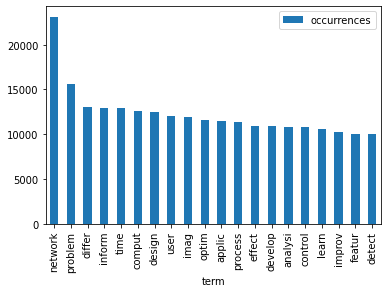

In [119]:
counts_df.sort_values(by='occurrences', ascending=False).head(20).plot.bar(x='term')

In [120]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<35174x3284 sparse matrix of type '<class 'numpy.float64'>'
	with 1993480 stored elements in Compressed Sparse Row format>

In [121]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
1900,network,0.026550
2266,problem,0.018491
1359,imag,0.017529
622,control,0.016351
3149,user,0.016093
783,design,0.015851
560,comput,0.015814
1428,inform,0.015417
2004,optim,0.015345
2998,time,0.015192


In [122]:
df2.head()

,abstract,authors,n_citation,references,title,venue,year,id,text,stemmed
0,AdaBoost algorithm based on Haarlike features ...,"[Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...",0,"[0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...",A Heterogeneous System for RealTime Detection ...,high performance computing and communications,2016,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,AdaBoost algorithm based on Haarlike features ...,adaboost algorithm base on haarlik featur can ...
1,In this paper a kind of novel jigsaw EBG struc...,"[Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]",0,[],A novel conformal jigsaw EBG structure design,international conference on conceptual structures,2016,002e0b7e-d62f-4140-b015-1fe29a9acbaa,In this paper a kind of novel jigsaw EBG struc...,in this paper a kind of novel jigsaw ebg struc...
2,This paper studies the problem of using an aut...,"[Xiaodong Ai, Keyou You, Shiji Song]",0,"[1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...",A sourceseeking strategy for an autonomous und...,"international conference on control, automatio...",2016,00352759-f0a7-4678-82ae-fed68c700da6,This paper studies the problem of using an aut...,this paper studi the problem of use an autonom...
3,This paper presents a methodology to analyze l...,"[Vincent Buntinx, Cyril Bornet, Frédéric Kaplan]",0,"[426b57a8-2e7d-498d-9a57-c09983ae0699, 6499d57...",Studying Linguistic Changes over 200 Years of ...,Frontiers in Digital Humanities,2017,01522369-3b88-4256-99d4-4e0c1de9f1ba,This paper presents a methodology to analyze l...,this paper present a methodolog to analyz ling...
4,Container identification and recognition is st...,"[Ankit Verma, Monika Sharma, Ramya Hebbalagupp...",0,"[3e3a4245-eb62-4769-bc84-1001479df701, 42f6b97...",Automatic Container Code Recognition via Spati...,international conference on machine learning a...,2016,017440d5-6ba8-422a-bd7a-d59e3b9a4e77,Container identification and recognition is st...,contain identif and recognit is still perform ...


In [123]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35174 entries, 0 to 35173
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract    35174 non-null  object
 1   authors     35174 non-null  object
 2   n_citation  35174 non-null  int64 
 3   references  35174 non-null  object
 4   title       35174 non-null  object
 5   venue       35174 non-null  object
 6   year        35174 non-null  int64 
 7   id          35174 non-null  object
 8   text        35174 non-null  object
 9   stemmed     35174 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.7+ MB


In [124]:
dfG=df2[['id', 'references']].copy()
dfG.set_index(['id'])
dfG['references'].tolist()
dfG=dfG.explode('references')
dfG.head()

,id,references
0,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,0a11984c-ab6e-4b75-9291-e1b700c98d52
0,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,1f4152a3-481f-4adf-a29a-2193a3d4303c
0,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,3c2ddf0a-237b-4d17-8083-c90df5f3514b
0,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,522ce553-29ea-4e0b-9ad3-0ed4eb9de065
0,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,579e5f24-5b13-4e92-b255-0c46d066e306


In [125]:
#create graph from exploded df
G = nx.from_pandas_edgelist(dfG, source='id', target='references', create_using=nx.DiGraph)

In [126]:
#import node attributes
nx.set_node_attributes(G, df2.set_index('id').to_dict('index'))

In [127]:
#test to make sure node attributes are imported
id1='ac2881d3-90aa-4610-b622-188afa7457f6'
year=nx.get_node_attributes(G,'year')
year[id1]

2016

In [128]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 300110\nNumber of edges: 446228\nAverage in degree:   1.4869\nAverage out degree:   1.4869'

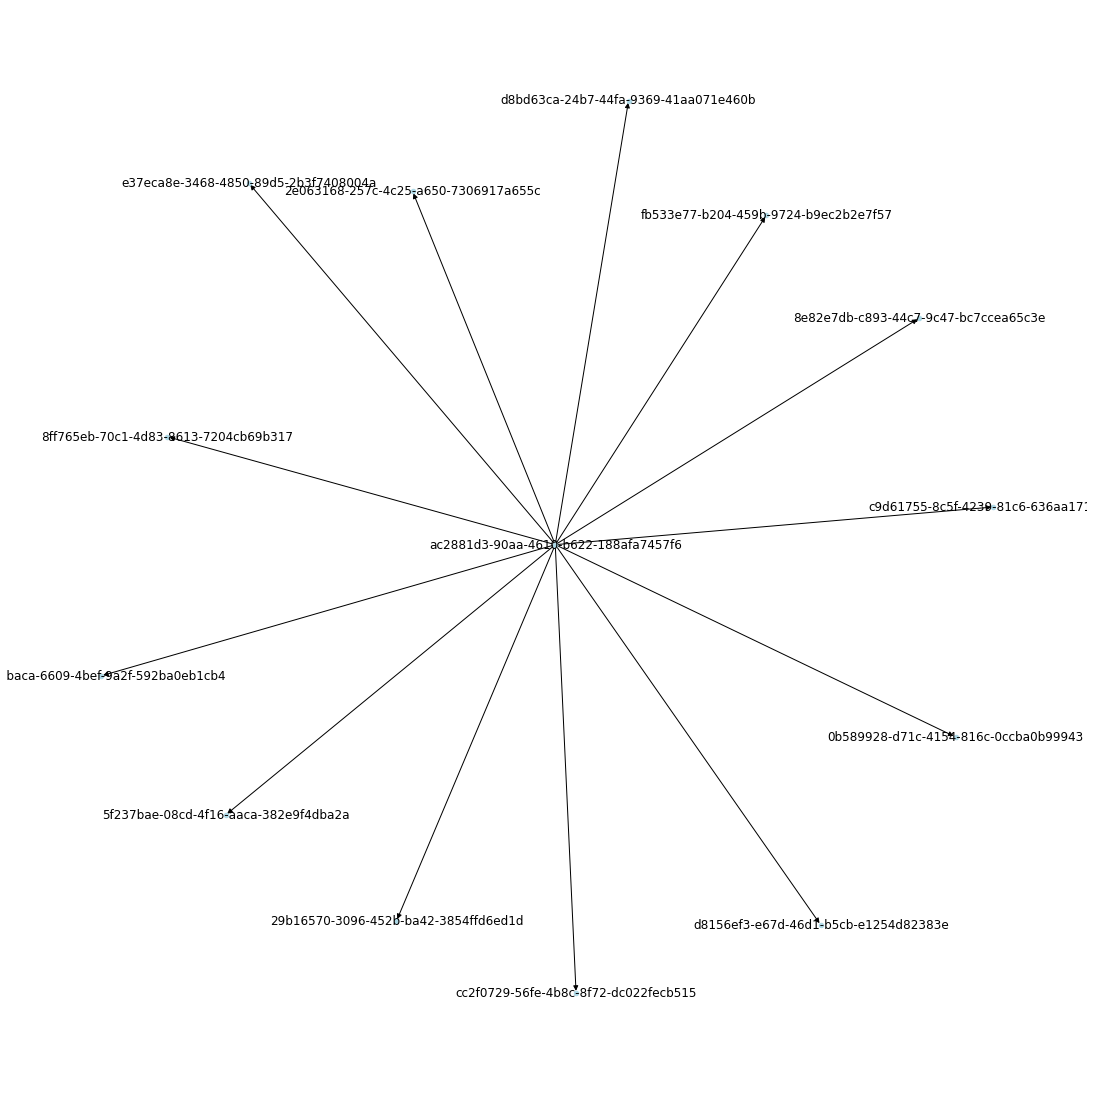

In [130]:
H= nx.ego_graph(G, id1, radius=2)
plt.figure(figsize = [15,15]) 
pos = nx.spring_layout(H) 
nx.draw(H, with_labels=True, node_size = 20 , node_color = 'lightblue')
plt.savefig('cite.png')

In [132]:
Gsub = G.subgraph(list(G.nodes)[0:25000])

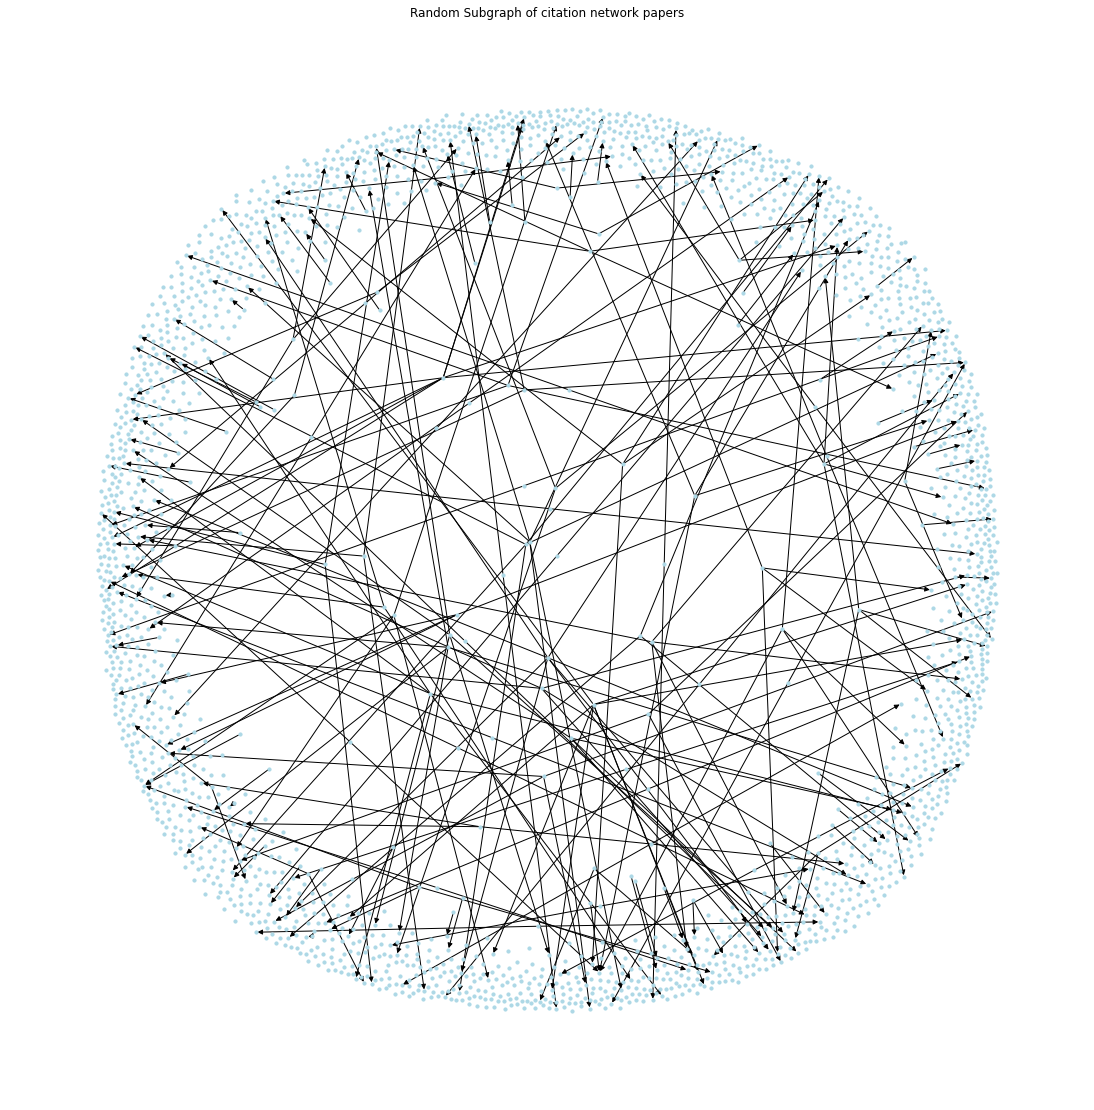

In [136]:
I= Gsub.subgraph(random.sample(list(Gsub.nodes), 2500))
plt.figure(figsize = [15,15]) 
pos = nx.spring_layout(H) 
nx.draw(H, with_labels=False, node_size = 10 , node_color = 'lightblue')
plt.title(f'Random Subgraph of citation network papers')
plt.savefig('cite.png')